In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve,precision_score, f1_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# --- Load datasets ---
mrs_1month_df = pd.read_csv('/Volumes/evan_ext/GeneACTIV Analysis/Data/1_Month_mRS.csv')
mrs_6month_df = pd.read_csv('/Volumes/evan_ext/GeneACTIV Analysis/Data/6_Month_mRS.csv')

# --- Merge without dropping partial rows ---
mrs_combined_df = pd.merge(
    mrs_1month_df,
    mrs_6month_df,
    on='ID',
    how='outer',   # <--- outer keeps all subjects
    suffixes=(' 1mo', ' 6mo')
)

# Clean ID column
mrs_combined_df.dropna(subset=['ID'], inplace=True)

# --- Directory containing the Move Files ---
move_dir = "/Volumes/evan_ext/GeneACTIV Analysis/Data/Move Files"

# --- Extract numeric IDs from filenames ---
move_ids = []
for fname in os.listdir(move_dir):
    match = re.match(r"MOVE(\d+)\.csv$", fname)
    if match:
        move_ids.append(int(match.group(1)))  # store as int

move_ids = sorted(move_ids)
print(f"Found {len(move_ids)} Move Files with valid IDs")

# --- Clean mRS IDs (convert float IDs like 51348.0 -> 51348) ---
mrs_combined_df['ID'] = pd.to_numeric(mrs_combined_df['ID'], errors='coerce').astype('Int64')

# --- Intersect IDs ---
valid_ids = set(move_ids).intersection(set(mrs_combined_df['ID'].dropna().astype(int)))

print(f"Number of IDs present in both mRS and Move files: {len(valid_ids)}")

# --- Filter mRS dataframe to only those IDs ---
mrs_combined_df = mrs_combined_df[mrs_combined_df['ID'].isin(valid_ids)].reset_index(drop=True)

print(f"Filtered dataframe shape: {mrs_combined_df.shape}")

# Convert scores to numeric safely
mrs_combined_df['1 month smRS'] = pd.to_numeric(mrs_combined_df['1 month smRS'], errors='coerce')
mrs_combined_df['6 month smRS'] = pd.to_numeric(mrs_combined_df['6 month smRS'], errors='coerce')

# --- Safe binary conversions ---
def safe_binary(x):
    if pd.isna(x):
        return np.nan
    return 1 if x > 2 else 0

mrs_combined_df['mRS_1mo_binary'] = mrs_combined_df['1 month smRS'].apply(safe_binary)
mrs_combined_df['mRS_6mo_binary'] = mrs_combined_df['6 month smRS'].apply(safe_binary)

# Compute difference only when both values exist
valid_mask = mrs_combined_df[['1 month smRS', '6 month smRS']].notna().all(axis=1)
mrs_combined_df.loc[valid_mask, 'mRS_dif'] = (
    mrs_combined_df.loc[valid_mask, '6 month smRS'] -
    mrs_combined_df.loc[valid_mask, '1 month smRS']
)
mrs_combined_df['mRS_dif_binary'] = mrs_combined_df['mRS_dif'].apply(
    lambda x: np.nan if pd.isna(x) else (1 if x > 0 else 0)
)

Found 524 Move Files with valid IDs
Number of IDs present in both mRS and Move files: 362
Filtered dataframe shape: (362, 9)


In [2]:
# --- Create mapping from ID -> full file path ---
id_to_path = {}
for fname in os.listdir(move_dir):
    match = re.match(r"MOVE(\d+)\.csv$", fname)
    if match:
        move_id = int(match.group(1))
        id_to_path[move_id] = os.path.join(move_dir, fname)

# --- Build the reduced dataframe ---
final_df = mrs_combined_df[['ID', 'mRS_1mo_binary', 'mRS_6mo_binary', 'mRS_dif_binary']].copy()

# Map each ID to its file path (or NaN if missing)
final_df['move_file_path'] = final_df['ID'].apply(lambda x: id_to_path.get(int(x), np.nan))

# --- Optional: sanity check ---
print(f"Final dataframe shape: {final_df.shape}")

Final dataframe shape: (362, 5)


In [3]:
# --- Label summaries ---
label_columns = ['mRS_1mo_binary', 'mRS_6mo_binary', 'mRS_dif_binary']
label_info = {
    col: {
        'num_samples': int(final_df[col].notna().sum()),
        'class_distribution': final_df[col].value_counts(dropna=True).to_dict(),
        'class_distribution_percent': (
            mrs_combined_df[col].value_counts(normalize=True, dropna=True) * 100
        ).round(2).to_dict()
    }
    for col in label_columns
}

label_info

{'mRS_1mo_binary': {'num_samples': 302,
  'class_distribution': {0.0: 231, 1.0: 71},
  'class_distribution_percent': {0.0: 76.49, 1.0: 23.51}},
 'mRS_6mo_binary': {'num_samples': 251,
  'class_distribution': {0.0: 184, 1.0: 67},
  'class_distribution_percent': {0.0: 73.31, 1.0: 26.69}},
 'mRS_dif_binary': {'num_samples': 191,
  'class_distribution': {0.0: 145, 1.0: 46},
  'class_distribution_percent': {0.0: 75.92, 1.0: 24.08}}}

In [4]:
import pandas as pd
import numpy as np

def causal_rolling_mean(s, window):
    # trailing window; no peeking
    return s.rolling(window=window, min_periods=1).mean()

def median_despike(s, window):
    return s.rolling(window=window, min_periods=1).median()

def epoch_accel_data(file_name, smooth=None, smooth_window=5, max_days=30):
    """
    Process MOVE accelerometry CSV file and extract 15-second resampled epochs
    for up to the first 30 days of recording.

    Returns:
        epochs (np.ndarray): [num_days, 5760, 1] array of daily epochs
        mean_timeseries (np.ndarray): [5760,] average vector magnitude over days
    """
    try:
        df = pd.read_csv(
            file_name,
            skiprows=100,
            usecols=[0, 7],  # timestamp + vector magnitude only
            names=['Timestamp', 'vector-magnitudes']
        )

        # --- Parse timestamps and sort ---
        df['Timestamp'] = pd.to_datetime(df['Timestamp'],
                                     format='%Y-%m-%d %H:%M:%S:%f',
                                     errors='coerce')
    
        df = df.dropna(subset=['Timestamp']).sort_values('Timestamp')

        if df.empty:
            return None, None

        # --- Start at first full day boundary ---
        first_full_day = df['Timestamp'].dt.normalize().iloc[0] + pd.Timedelta(days=1)
        df = df[df['Timestamp'] >= first_full_day].set_index('Timestamp')

        if df.empty:
            return None, None

        # --- Regularize to 15-second bins ---
        df = df.resample('15s').mean()

        # --- Interpolate conservatively ---
        df['vector-magnitudes'] = df['vector-magnitudes'].interpolate(method='time', limit_direction='both').ffill().bfill()

        # --- Optional smoothing ---
        if smooth in ('mean', 'median') and smooth_window > 1:
            if smooth == 'mean':
                df['vector-magnitudes'] = causal_rolling_mean(df['vector-magnitudes'], smooth_window)
            else:
                df['vector-magnitudes'] = median_despike(df['vector-magnitudes'], smooth_window)

        # --- Keep only complete 15-second days ---
        start = df.index[0].normalize()
        end = df.index[-1].normalize() + pd.Timedelta(days=1)
        df = df.loc[start:end - pd.Timedelta(seconds=15)]
        n = len(df)
        num_days = n // 5760  # 5760 samples per 24h at 15s intervals
        df = df.iloc[:num_days * 5760]

        if num_days == 0:
            return None, None

        # --- Truncate to first 30 days if longer ---
        num_days = min(num_days, max_days)
        df = df.iloc[:num_days * 5760]

        # --- Build daily epochs ---
        arr = df['vector-magnitudes'].to_numpy(dtype=np.float32)
        epochs = arr.reshape(num_days, 5760, 1)

        # --- Compute mean daily timeseries (feature summary) ---
        mean_timeseries = np.mean(epochs, axis=0).flatten()

        return epochs, mean_timeseries

    except Exception as e:
        print(f"⚠️ Failed to process {file_name}: {e}")
        return None, None
    
feature_records = []

for i, row in final_df.iterrows():
    file_path = row['move_file_path']
    epochs, mean_ts = epoch_accel_data(file_path, smooth='mean', smooth_window=5, max_days=30)
    
    if mean_ts is not None:
        feature_records.append({
            'ID': row['ID'],
            'mRS_1mo_binary': row['mRS_1mo_binary'],
            'mRS_6mo_binary': row['mRS_6mo_binary'],
            'mRS_dif_binary': row['mRS_dif_binary'],
            'move_file_path': file_path,
            'features': mean_ts
        })

# Convert to dataframe
features_df = pd.DataFrame(feature_records)
print(f"✅ Extracted features for {len(features_df)} participants (out of {len(final_df)})")

# Drop any rows where feature extraction failed automatically
features_df = features_df.dropna(subset=['features']).reset_index(drop=True)

✅ Extracted features for 361 participants (out of 362)


In [5]:
# --- Label summaries ---
label_columns = ['mRS_1mo_binary', 'mRS_6mo_binary', 'mRS_dif_binary']
label_info = {
    col: {
        'num_samples': int(features_df[col].notna().sum()),
        'class_distribution': features_df[col].value_counts(dropna=True).to_dict(),
        'class_distribution_percent': (
            mrs_combined_df[col].value_counts(normalize=True, dropna=True) * 100
        ).round(2).to_dict()
    }
    for col in label_columns
}

label_info

{'mRS_1mo_binary': {'num_samples': 301,
  'class_distribution': {0.0: 230, 1.0: 71},
  'class_distribution_percent': {0.0: 76.49, 1.0: 23.51}},
 'mRS_6mo_binary': {'num_samples': 251,
  'class_distribution': {0.0: 184, 1.0: 67},
  'class_distribution_percent': {0.0: 73.31, 1.0: 26.69}},
 'mRS_dif_binary': {'num_samples': 191,
  'class_distribution': {0.0: 145, 1.0: 46},
  'class_distribution_percent': {0.0: 75.92, 1.0: 24.08}}}

In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, precision_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import tensorflow as tf
from xgboost import XGBClassifier   # ✅ Added XGBoost import

# --- Ensure reproducibility ---
np.random.seed(42)
tf.random.set_seed(42)

# --- LSTM model builder ---
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(32))
    model.add(Dropout(0.5))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

# --- Prepare features & labels ---
def prepare_data(features_df, label_name):
    X = np.stack(features_df['features'].to_numpy())  # shape: (N, 5760)
    y = features_df[label_name].to_numpy().astype(int)
    return X, y

# --- Classical ML pipelines ---
def build_rf_pipeline():
    return Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('rf', RandomForestClassifier(
            n_estimators=300, max_depth=None, random_state=42, n_jobs=-1))
    ])

def build_lr_pipeline():
    return Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('lr', LogisticRegression(max_iter=1000, random_state=42))
    ])

# ✅ XGBoost pipeline
def build_xgb_pipeline():
    return Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('xgb', XGBClassifier(
            n_estimators=500,
            max_depth=6,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            eval_metric='logloss',
            use_label_encoder=False,
            random_state=42,
            n_jobs=-1
        ))
    ])

from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, roc_curve
from sklearn.utils import resample

# --- Bootstrap CI helper ---
def bootstrap_ci(y_true, y_pred, metric_fn, n_boot=2000, alpha=0.05, random_state=42):
    rng = np.random.default_rng(random_state)
    stats = []
    for _ in range(n_boot):
        idx = rng.integers(0, len(y_true), len(y_true))
        yb, pb = y_true[idx], y_pred[idx]
        stats.append(metric_fn(yb, pb))
    stats = np.sort(stats)
    lo = np.percentile(stats, 100 * alpha / 2)
    hi = np.percentile(stats, 100 * (1 - alpha / 2))
    return np.mean(stats), (lo, hi)

# --- Metric computation wrapper ---
def compute_metrics(y_true, y_pred_prob):
    y_pred_bin = (y_pred_prob >= 0.5).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_bin).ravel()
    sens = tp / (tp + fn + 1e-9)
    spec = tn / (tn + fp + 1e-9)
    f1 = f1_score(y_true, y_pred_bin)
    ppv = precision_score(y_true, y_pred_bin)
    rec = recall_score(y_true, y_pred_bin)
    auroc = roc_auc_score(y_true, y_pred_prob)
    return dict(AUROC=auroc, Sensitivity=sens, Specificity=spec,
                F1=f1, Precision=ppv, Recall=rec)

# --- Evaluation loop with CIs and ROC data ---
def evaluate_models(features_df, labels=['mRS_1mo_binary', 'mRS_6mo_binary', 'mRS_dif_binary'], n_boot=2000):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    results = []

    for label_name in labels:
        print(f"\n====================== Evaluating Label: {label_name} ======================")
        valid_df = features_df[~features_df[label_name].isna()].reset_index(drop=True)
        if valid_df.empty:
            print(f"⚠️ Skipping {label_name}: no valid samples.")
            continue

        X, y = prepare_data(valid_df, label_name)
        X_lstm = X.reshape(X.shape[0], X.shape[1], 1)

        metrics_summary = {}

        def cv_predictions(pipe_or_model, X, y, is_lstm=False):
            y_true_all, y_pred_all = [], []
            for train_idx, test_idx in skf.split(X, y):
                if is_lstm:
                    X_train, X_test = X[train_idx], X[test_idx]
                    y_train, y_test = y[train_idx], y[test_idx]
                    X_train_flat = X_train.reshape(X_train.shape[0], -1)
                    sm = SMOTE(random_state=42)
                    X_train_res, y_train_res = sm.fit_resample(X_train_flat, y_train)
                    X_train_res = X_train_res.reshape(X_train_res.shape[0], X.shape[1], 1)

                    scaler = StandardScaler()
                    X_train_res = scaler.fit_transform(
                        X_train_res.reshape(X_train_res.shape[0], -1)
                    ).reshape(X_train_res.shape)
                    X_test_scaled = scaler.transform(
                        X_test.reshape(X_test.shape[0], -1)
                    ).reshape(X_test.shape)

                    model = create_lstm_model((X_train_res.shape[1], 1))
                    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
                    model.fit(X_train_res, y_train_res, validation_split=0.2,
                              epochs=30, batch_size=32, verbose=0, callbacks=[es])
                    preds = model.predict(X_test_scaled).flatten()
                else:
                    pipe_or_model.fit(X[train_idx], y[train_idx])
                    preds = pipe_or_model.predict_proba(X[test_idx])[:, 1]
                    y_test = y[test_idx]
                y_true_all.extend(y_test)
                y_pred_all.extend(preds)
            return np.array(y_true_all), np.array(y_pred_all)

        # --- Models ---
        models = {
            'RF': build_rf_pipeline(),
            'LR': build_lr_pipeline(),
            'XGB': build_xgb_pipeline(),
            'LSTM': 'LSTM'
        }

        for name, model in models.items():
            print(f"\n---- Evaluating {name} ----")
            if name == 'LSTM':
                y_true_all, y_pred_all = cv_predictions(None, X_lstm, y, is_lstm=True)
            else:
                y_true_all, y_pred_all = cv_predictions(model, X, y)

            # Base metrics
            base_metrics = compute_metrics(y_true_all, y_pred_all)

            # Bootstrap CIs
            ci_dict = {}
            for metric, value in base_metrics.items():
                def metric_fn(yb, pb, m=metric):
                    return compute_metrics(yb, pb)[m]
                mean_val, (lo, hi) = bootstrap_ci(y_true_all, y_pred_all, metric_fn, n_boot=n_boot)
                ci_dict[metric] = (mean_val, lo, hi)

            # --- NEW: Compute and store ROC curve points ---
            fpr, tpr, thresholds = roc_curve(y_true_all, y_pred_all)
            ci_dict["fpr"] = fpr
            ci_dict["tpr"] = tpr
            ci_dict["thresholds"] = thresholds

            metrics_summary[name] = ci_dict

            print(f"{name} summary:")
            for k, v in ci_dict.items():
                if k in ['fpr', 'tpr', 'thresholds']:
                    continue
                mean_val, lo, hi = v
                print(f"  {k}: {mean_val:.3f} (95% CI {lo:.3f}–{hi:.3f})")

        results.append((label_name, metrics_summary))

    return results


/Users/shaunkohli/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [7]:
# results = evaluate_models(features_df=features_df)

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc

def plot_roc_curves(results):
    """
    Plot ROC curves for Logistic Regression (LR), Random Forest (RF), and LSTM models
    using ROC data stored in the results object from evaluate_models().
    """
    n_labels = len(results)
    fig, axes = plt.subplots(1, n_labels, figsize=(7 * n_labels, 6))
    if n_labels == 1:
        axes = [axes]  # Ensure iterable for single plot

    # --- consistent, colorblind-friendly palette ---
    model_colors = {
        'LR': '#2ca02c',     # green
        'RF': '#1f77b4',     # blue
        'LSTM': '#d62728'    # red
    }

    for ax, (label_name, metrics_summary) in zip(axes, results):
        print(f"\n📈 Plotting ROC curves for {label_name}...")

        for model_name in ['LR', 'RF', 'LSTM']:  # ✅ only these 3 models
            if model_name not in metrics_summary:
                continue

            scores = metrics_summary[model_name]

            # Ensure fpr/tpr exist (computed during evaluate_models)
            if 'fpr' not in scores or 'tpr' not in scores:
                print(f"⚠️ Skipping {model_name}: missing fpr/tpr.")
                continue

            fpr, tpr = scores['fpr'], scores['tpr']
            auroc = scores['AUROC'][0]  # ✅ mean AUROC value (first element of tuple)
            auroc_lo, auroc_hi = scores['AUROC'][1], scores['AUROC'][2]  # ✅ 95% CI bounds

            color = model_colors.get(model_name, None)
            ax.plot(
                fpr, tpr,
                label=f"{model_name} (AUROC = {auroc:.3f} [{auroc_lo:.3f}–{auroc_hi:.3f}])",
                linewidth=2, color=color
            )

        # --- Diagonal reference line (chance level) ---
        ax.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=1)

        # --- Axis labels, title, and formatting ---
        ax.set_xlabel('False Positive Rate', fontsize=12)
        ax.set_ylabel('True Positive Rate', fontsize=12)
        ax.set_title(f"ROC Curves – {label_name}", fontsize=14, fontweight='bold')
        ax.legend(loc='lower right', fontsize=10, frameon=False)
        ax.grid(True, linestyle=':', linewidth=0.7, alpha=0.7)
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])

    plt.tight_layout()
    plt.show()


📈 Plotting ROC curves for mRS_1mo_binary...

📈 Plotting ROC curves for mRS_6mo_binary...

📈 Plotting ROC curves for mRS_dif_binary...


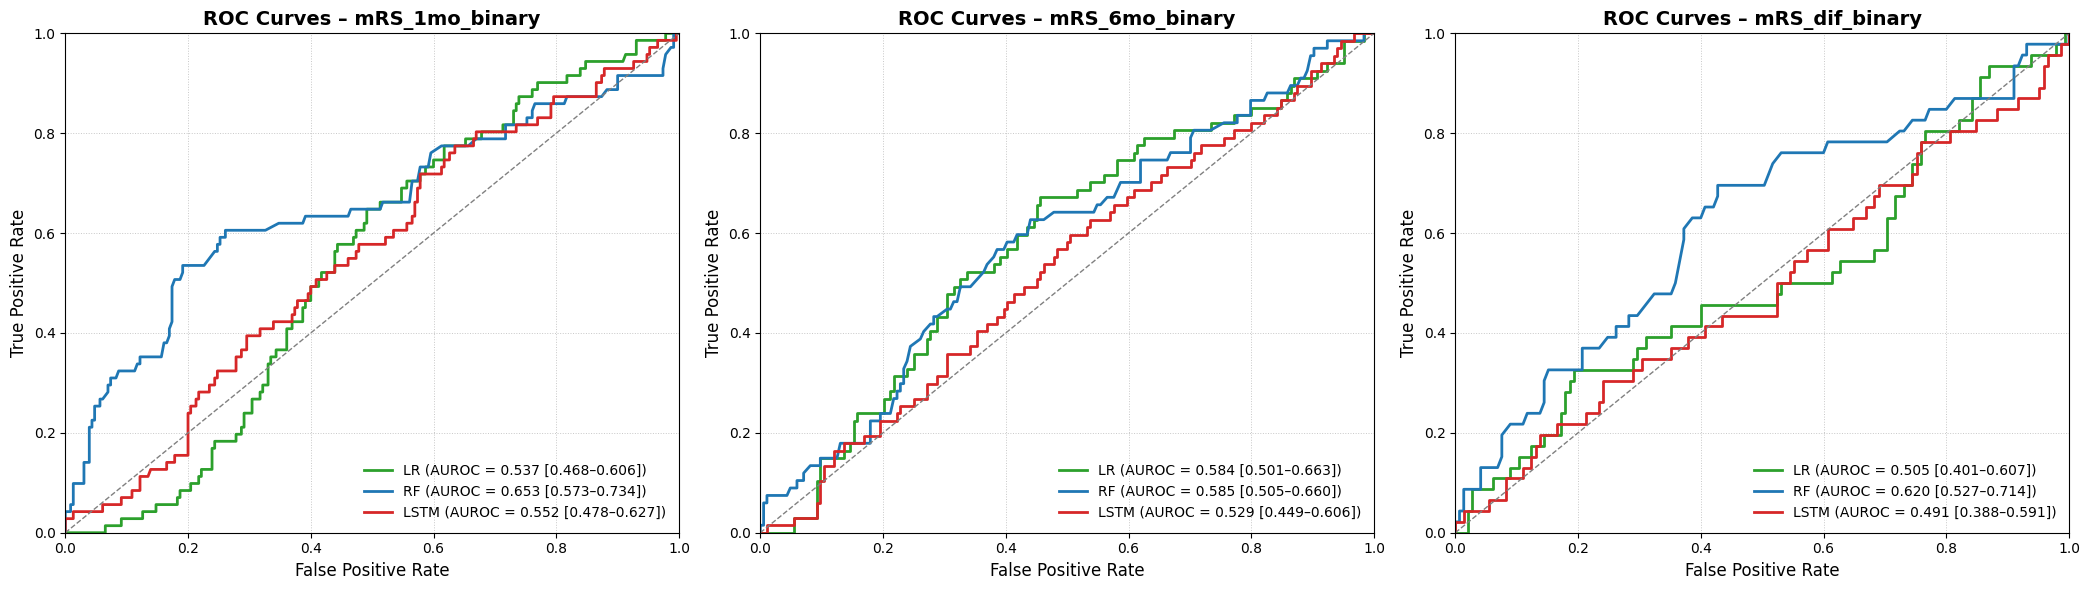

In [9]:
plot_roc_curves(results)

In [10]:
import pickle
import os

# --- Define desktop path (works on Windows, macOS, Linux) ---
desktop = os.path.join(os.path.expanduser("~"), "Desktop")

# --- File path ---
file_path = os.path.join(desktop, "model_results.pkl")

# --- Save results object ---
with open(file_path, "wb") as f:
    pickle.dump(results, f)

print(f"✅ Results object saved to: {file_path}")


✅ Results object saved to: /Users/shaunkohli/Desktop/model_results.pkl


In [11]:
# --- To load it later ---
with open(file_path, "rb") as f:
   results_loaded = pickle.load(f)
print("✅ Results object reloaded successfully.")

✅ Results object reloaded successfully.


In [12]:
results_loaded

[('mRS_1mo_binary',
  {'RF': {'AUROC': (np.float64(0.6534630708510046),
     np.float64(0.5726599876001576),
     np.float64(0.7343882199772563)),
    'Sensitivity': (np.float64(0.3527149009156026),
     np.float64(0.23877332089197298),
     np.float64(0.46969696968985303)),
    'Specificity': (np.float64(0.8737036722115242),
     np.float64(0.8281903442465535),
     np.float64(0.9145390070882907)),
    'F1': (np.float64(0.39775271056614747),
     np.float64(0.2833296460176991),
     np.float64(0.5038167938931297)),
    'Precision': (np.float64(0.4613611763578923),
     np.float64(0.3333333333333333),
     np.float64(0.6)),
    'Recall': (np.float64(0.3527149009206459),
     np.float64(0.2387733208955224),
     np.float64(0.4696969696969697)),
    'fpr': array([0.        , 0.        , 0.        , 0.00869565, 0.00869565,
           0.01304348, 0.01304348, 0.02173913, 0.03043478, 0.03043478,
           0.03913043, 0.03913043, 0.03913043, 0.04347826, 0.04347826,
           0.04782609, 0.0